In [1]:
import pandas as pd    
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 1. Data Exploration

In [3]:
disney = pd.read_csv("subreddit_DisneyPlus_data.csv")
netflix = pd.read_csv("subreddit_netflix_data.csv")

In [4]:
disney.head()

,title,score,id,url,comms_num,created,body
0,Monthly Tech Support & Missing Content Thread,2,1ggy19d,https://www.reddit.com/r/DisneyPlus/comments/1...,39,2024-11-01 12:01:37,All posts regarding tech support or missing co...
1,The Simpsons: Treehouse of Horror XXXV - now s...,60,1gkbwwp,https://i.redd.it/xwpcgk4n94zd1.jpeg,12,2024-11-06 00:18:57,NaN
2,What do you think of Bolt?,8,1gpfceh,https://i.redd.it/m4dgy1b8af0e1.jpeg,1,2024-11-12 14:25:35,I think this movie deserves a lot of attention...
3,New official poster for 'What If...?' Season 3,85,1goxum0,https://i.redd.it/yc5mfxwk5b0e1.jpeg,21,2024-11-12 00:32:33,NaN
4,‘High Potential’ Premiere Draws Over 20 Millio...,12,1gpayc9,https://www.thewrap.com/high-potential-premier...,1,2024-11-12 09:58:42,NaN


In [5]:
netflix.head()

,title,score,id,url,comms_num,created,body
0,/r/Netflix Discord Server,479,mxm3re,https://www.reddit.com/r/netflix/comments/mxm3...,249,2021-04-24 22:24:04,We are pleased to announce we have affiliated ...
1,Enough Mark Wahlberg!,235,1gpas31,https://www.reddit.com/r/netflix/comments/1gpa...,63,2024-11-12 09:49:41,He plays the same character in every movie! He...
2,Windows lagging?,63,1gp72oi,https://www.reddit.com/r/netflix/comments/1gp7...,84,2024-11-12 06:50:30,Just a quick question \nIs anyone elses netfli...
3,No Netflix interface when watching on PC?,34,1gp75y3,https://www.reddit.com/r/netflix/comments/1gp7...,22,2024-11-12 06:54:45,"As said in the title, what happened to the int..."
4,Netflix broken?,21,1gp7n93,https://www.reddit.com/r/netflix/comments/1gp7...,12,2024-11-12 07:17:00,"So, I'm assuming netflix is broken for everyon..."


In [6]:
netflix.isnull().sum()

title          0
score          0
id             0
url            0
comms_num      0
created        0
body         128
dtype: int64

In [7]:
disney.isnull().sum()

title          0
score          0
id             0
url            0
comms_num      0
created        0
body         262
dtype: int64

# 2. Data Cleaning

In [9]:
# Drop unused columns ['id','url','created']
netflix = netflix.drop(columns=['id','url','created','body'])
disney = disney.drop(columns=['id','url','created','body'])

In [10]:
# Check the shape
netflix.shape, disney.shape

((535, 3), (930, 3))

In [11]:
# Add platform column 
# Netflix = 1
# Disney+ Hotstar = 0
netflix.insert(1, "is_netflix", 1)
disney.insert(1,"is_netflix", 0)

In [12]:
df = pd.concat([netflix,disney],axis=0)

In [13]:
df

,title,is_netflix,score,comms_num
0,/r/Netflix Discord Server,1,479,249
1,Enough Mark Wahlberg!,1,235,63
2,Windows lagging?,1,63,84
3,No Netflix interface when watching on PC?,1,34,22
4,Netflix broken?,1,21,12
...,...,...,...,...
925,NEW POSTER for FX's The Bear Season 3 | Premie...,0,57,12
926,Will Disney+ work in UAE from Australia?,0,5,5
927,Speech audio,0,11,4
928,Reminder: This is a fan-run community. We don'...,0,133,25


In [14]:
df.isnull().sum()

title         0
is_netflix    0
score         0
comms_num     0
dtype: int64

In [15]:
df['is_netflix'].value_counts(normalize=True) #thus we use Disney as the baseline of 63%.

is_netflix
0    0.634812
1    0.365188
Name: proportion, dtype: float64

# 3. Preprocessing

In [17]:
# Change title lowercase
df['title'] = df['title'].map(lambda x: x.lower())

In [18]:
df['title'].head()

0                    /r/netflix discord server
1                        enough mark wahlberg!
2                             windows lagging?
3    no netflix interface when watching on pc?
4                              netflix broken?
Name: title, dtype: object

In [19]:
# Remove special characters ()
df['title'] = df['title'].str.replace(pat=r'\W+', repl=" ", regex=True)

In [20]:
# Remove Netflix and Disney
df['title'] = df['title'].str.replace('netflix', repl="", regex=True).str.replace('disney', repl="", regex=True)

In [21]:
# Replace 'fo' with 'to'
df['title'] = df['title'].str.replace('fo r', repl='for', regex=True)

## Lemmatize

In [23]:
# Setup stop words and lemmatizer
ENGLISH_STOP_WORDS = CountVectorizer(stop_words='english').get_stop_words()
lemmatizer = WordNetLemmatizer()
lemma_stops = {lemmatizer.lemmatize(word) for word in ENGLISH_STOP_WORDS}

# The creation of `all_stops`! What a time to be alive.
# We'll create a comprehensive stop words set that combines:
# 1. Original stop words from ENGLISH_STOP_WORDS
# 2. Their lemmatized forms from lemma_stops (e.g., 'was'->'wa', 'has'->'ha')
# This should ensure we catch stop words regardless of their form
all_stops = set(ENGLISH_STOP_WORDS).union(lemma_stops)

def lemma_tokenize(text):
   tokens = word_tokenize(text)
   # Process each word by:
   # 1. Lemmatizing it (e.g., 'running' -> 'run')
   # 2. Checking if it's >1 character AND not in `all_stops` (our combined regular+lemmatized stop words)
   # This should ensure we remove stop words in any form (original or lemmatized)
   return [lemmatizer.lemmatize(word) for word in tokens if len(word) > 1 and word not in all_stops]

# The function above then gets passed to the CountVectorizer during instantiation:
# cvec = CountVectorizer(max_features=500, tokenizer=lemma_tokenize)

# 4. Model

In [25]:
X = df['title']
y = df['is_netflix']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y,random_state=42)

In [26]:
import warnings
warnings.filterwarnings('ignore', message=r"The parameter 'token_pattern' will not be used since 'tokenizer' is not None'")

In [27]:
# Instantiate a CountVectorizer (removed stop_words parameter)
cvec = CountVectorizer(max_features=500, tokenizer=lemma_tokenize)

def get_word_mappings(text):
  tokens = word_tokenize(text)
  # Create dictionary of all words and their lemmatized forms
  mappings = {word: lemmatizer.lemmatize(word) for word in tokens}
  # NOTE: Removed >1 character condition as it no longer serves us
  # Filter to keep only words that changed during lemmatization (e.g., 'running'->'run')
  changed_words = {original: lemma for original, lemma in mappings.items() if original != lemma}
  return changed_words

# Store the lemmatization changes before transforming
lemma_changes = get_word_mappings(" ".join(X_train))

# Continue with fit and transform
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [28]:
# UserWarning: Your stop_words may be inconsistent with your preprocessing. 
# Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.

# A more interesting UserWarning. It's telling us that when our lemmatizer processes the stop words, 
# it's creating some tokens that aren't in the original stop words list. 
# While we already have these lemmatized forms in `all_stops`, we weren't using them because
# we were double-handling stop words by using CountVectorizer with both 
# tokenizer=lemma_tokenize AND stop_words='english'. 
# Workable but not ideal. Instead let's try using `all_stops` 
# in the tokenizer and remove stop_words from CountVectorizer.

# Let's see the impact of this. 

In [29]:
# The `lemma_changes` variable "holds" a dictionary with the pre-lemmatized 
# word as a key and the lemmatized word as the value
print(len(lemma_changes))

311


In [30]:
[word for word, lemma in lemma_changes.items() if lemma == "wa"]
[word for word, lemma in lemma_changes.items() if lemma in ["wa", "le", "ha", "u"]]

# Words from the UserWarning
# "ha" appears to be from "has"
# "le" appears to be from "less" and "les"
# "u" appears to be from "us"
# "wa" appears to be from"was"

['has', 'less', 'was', 'les', 'us']

In [31]:
X_train_cvec, X_test_cvec

(<1172x500 sparse matrix of type '<class 'numpy.int64'>'
 	with 3740 stored elements in Compressed Sparse Row format>,
 <293x500 sparse matrix of type '<class 'numpy.int64'>'
 	with 853 stored elements in Compressed Sparse Row format>)

In [32]:
pd.DataFrame(X_train_cvec.toarray(), columns=cvec.get_feature_names_out()).head()

,10,12,15,17,1997,2024,2025,2026,21,30,...,work,working,world,worst,worth,wrong,year,youtube,zootopia,zootropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
nb = MultinomialNB()
model = nb.fit(X_train_cvec,y_train)
y_preds = nb.predict(X_test_cvec)

In [34]:
nb.score(X_test_cvec,y_test)

0.7815699658703071

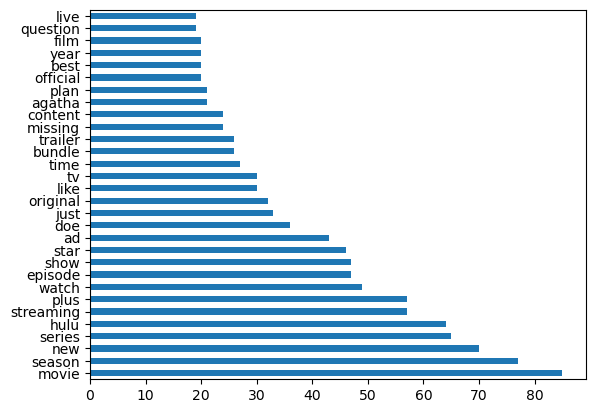

In [35]:
X_train_df = pd.DataFrame(X_train_cvec.todense(), 
                          columns=cvec.get_feature_names_out())
X_train_df.sum().sort_values(ascending=False).head(30).plot(kind='barh');

In [36]:
X_train_df.columns

Index(['10', '12', '15', '17', '1997', '2024', '2025', '2026', '21', '30',
       ...
       'work', 'working', 'world', 'worst', 'worth', 'wrong', 'year',
       'youtube', 'zootopia', 'zootropolis'],
      dtype='object', length=500)

In [37]:
pipe = Pipeline([
    ('cvec', CountVectorizer()), 
    ('nb', MultinomialNB())
])

In [38]:
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [1, 2,3],
    'cvec__max_df': [.90, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
}

In [39]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [40]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [41]:
gs.best_score_

0.7226732133115112

In [42]:
gs.score(X_train, y_train)

0.9547781569965871

In [43]:
gs.score(X_test, y_test) #checking for overfit

0.7815699658703071

In [44]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

## Model 2 Logistic Regression

In [46]:
# Logistic Regression is used because Logistic regression is the most common binary classification algorithm.

In [93]:
df.columns

Index(['title', 'is_netflix', 'score', 'comms_num'], dtype='object')

In [95]:
X_train_df

,10,12,15,17,1997,2024,2025,2026,21,30,...,work,working,world,worst,worth,wrong,year,youtube,zootopia,zootropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
X_train_cvec.shape, X_test_cvec.shape, y_train.shape, y_test.shape

((1172, 500), (293, 500), (1172,), (293,))

In [99]:
# Step 2: Instantiate our model #blueprint or lr class
logreg = LogisticRegression()

# Step 3: Fit our model
logreg.fit(X_train_cvec, y_train)

LogisticRegression()

In [101]:
print(f'Log REg coeff: {logreg.coef_}')
print(f'log reg intercept: {logreg.intercept_}')

Log REg coeff: [[-6.22737242e-01 -4.41109191e-01  2.78393892e-01  1.84851088e-01
  -3.13129888e-01  5.48082851e-01 -9.14178853e-01 -7.33546324e-02
   6.09696732e-01  8.47849375e-02 -6.61195727e-02  3.89670273e-01
   4.58653460e-01  1.53602236e-01 -5.67858748e-02 -4.45582535e-01
  -1.59836112e-02  1.09389128e-01  8.26848475e-01 -1.07908439e+00
   5.50287586e-01  6.95373491e-01  1.37089925e-02 -5.61598775e-01
  -2.76731307e-01 -8.04684304e-01 -4.04600190e-01 -1.68187172e+00
  -2.50051655e-01  1.66694633e-01 -7.14839798e-01 -2.99827451e-01
  -4.85343354e-02 -5.63739257e-01 -5.99440699e-01 -1.49039365e-01
   6.44487904e-01 -7.78889352e-01 -1.46223802e-01  4.82919562e-01
  -3.38582894e-02  3.04249204e-01 -3.15201410e-01 -7.95941444e-02
   1.82633851e-02  1.45493183e-01  1.52980011e+00 -1.45186613e-01
  -1.09514062e-02 -4.57893307e-01 -1.01726295e-01 -8.30916895e-01
   2.51056318e-01 -8.22312239e-01  7.80256294e-02  8.40695092e-01
   4.38433427e-02 -5.23731382e-01 -5.74579033e-01 -1.49528396

In [103]:
# Step 4 (part 1): Generate predicted values
logreg.predict(X_test_cvec)[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [105]:
X_test.head(10)

520               which plan is needed for the simpsons 
193                  i need some good series suggestions
815     marvel s what if to end after three seasons at  
407    audio falls out of sync when changing speed on...
612    six new star wars young jedi adventures shorts...
405                         a question about suggestions
860    how come tokyo revengers season 3 isn t out on...
13                        shows with no ads on  with ads
856       how often are the ads in the uk with standard 
348    best shows i ve watched few unpopular opinions...
Name: title, dtype: object

In [107]:
logreg.predict_proba(X_test_cvec)[:10] 

array([[8.42186916e-01, 1.57813084e-01],
       [6.00887758e-01, 3.99112242e-01],
       [7.76541673e-01, 2.23458327e-01],
       [6.87675050e-01, 3.12324950e-01],
       [9.89103799e-01, 1.08962008e-02],
       [6.19285676e-01, 3.80714324e-01],
       [9.99297282e-01, 7.02717768e-04],
       [7.62642005e-01, 2.37357995e-01],
       [9.39433482e-01, 6.05665181e-02],
       [7.04103675e-01, 2.95896325e-01]])

In [109]:
# Step 5: Evaluate model
logreg.score(X_train_cvec, y_train)

0.8540955631399317

In [111]:
logreg.score(X_test_cvec, y_test)

0.764505119453925

In [113]:
#baseline accuracy: what if the model just predicted the majority class for every 'is_netflix' prediction?
df['is_netflix'].value_counts(normalize=True) # note there are more netflix than disney in this dataset. 

#if we are beating the baseline of 63% disney class
#accuracy for our model is 76%, we are beating the baseline. 
#though our model is well above the baseline, the train accuracy is greater than the test, which is a sign of overfitting.

is_netflix
0    0.634812
1    0.365188
Name: proportion, dtype: float64

In [115]:
1- y.mean()

0.6348122866894198

## Regularize L2 and L1

In [118]:
# the key difference: 
# l1 penalties perform feature selection. That is, they often zero out parameters when they're small enough.

# While this sounds appealing, 
# l2 is used almost exclusively.

In [120]:
X_train_cvec

<1172x500 sparse matrix of type '<class 'numpy.int64'>'
	with 3740 stored elements in Compressed Sparse Row format>

## Grid Search

In [144]:
import numpy as np

lr = LogisticRegression(random_state=42)

lr_params = {'penalty': ['l1','l2'],
          'solver':['liblinear'],
          'C': np.logspace(-10,10,21)}

# Define the gridsearchCV
lr_grid = GridSearchCV(lr, param_grid=lr_params, cv=3, n_jobs=-1, verbose=1)

# fit with the tranformed sparse matrix
lr_grid.fit(X_train_cvec, y_train)
print('Best Score:', lr_grid.best_score_)

# assign the best estimator to a variable
best_lr = lr_grid.best_estimator_
print('Best Params:', lr_grid.best_params_)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
Best Score: 0.7081688416726779
Best Params: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
